In [2]:
import pandas as pd
import warnings
import chardet

# Read the file in binary mode
with open("EnergyData.csv", 'rb') as file:
    rawdata = file.read()

# Use result to find encoding for csv reading
result = chardet.detect(rawdata)
#print(result)

In [3]:
# Create function for mapping states to regions
def state_to_region(state_name):
    state_region_mapping = {
        # Northeast
        'Connecticut': 'Northeast', 'Maine': 'Northeast', 'Massachusetts': 'Northeast',
        'New Hampshire': 'Northeast', 'Rhode Island': 'Northeast', 'Vermont': 'Northeast',
        'New Jersey': 'Northeast', 'New York': 'Northeast', 'Pennsylvania': 'Northeast',

        # Midwest
        'Illinois': 'Midwest', 'Indiana': 'Midwest', 'Michigan': 'Midwest',
        'Ohio': 'Midwest', 'Wisconsin': 'Midwest', 'Iowa': 'Midwest', 
        'Kansas': 'Midwest', 'Minnesota': 'Midwest', 'Missouri': 'Midwest', 
        'Nebraska': 'Midwest', 'North Dakota': 'Midwest', 'South Dakota': 'Midwest',

        # South
        'Delaware': 'South', 'Florida': 'South', 'Georgia': 'South', 
        'Maryland': 'South', 'North Carolina': 'South', 'South Carolina': 'South', 
        'Virginia': 'South', 'West Virginia': 'South', 'Washington, D.C.': 'South', 
        'Alabama': 'South', 'Kentucky': 'South', 'Mississippi': 'South', 
        'Tennessee': 'South', 'Arkansas': 'South', 'Louisiana': 'South', 
        'Oklahoma': 'South', 'Texas': 'South',

        # West
        'Arizona': 'West', 'Colorado': 'West', 'Idaho': 'West', 
        'Montana': 'West', 'Nevada': 'West', 'New Mexico': 'West', 
        'Utah': 'West', 'Wyoming': 'West', 'Alaska': 'West', 
        'California': 'West', 'Hawaii': 'West', 'Oregon': 'West', 
        'Washington': 'West'
    }
    return state_region_mapping.get(state_name, 'US Territory')

# Define years we will be investigating
years = [year for year in range(2010, 2022)]

Below creates two data frames:

- transport_co2_ff: `Co2 emissions` for each state in each year
- transport_energy_ff: `Energy consumption` for each state in each year

In [4]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Read energy data set 
energy = pd.read_csv("EnergyData.csv", encoding='UTF-16', delimiter = "\t")

# Get transportation sector only
transport_energy = energy[energy["Sector"] == "Transportation"]

# Group by State, Year, and Measure
grouped_transport_energy = transport_energy.groupby(["State", 'Year of Year', 'Measure']).sum("Pivot Field Values").reset_index()

# Separate into energy consumption and co2 emmision data frames
grouped_transport_energy_consm = grouped_transport_energy[grouped_transport_energy['Measure'] == "Energy consumption (trillion Btu)"]
grouped_transport_energy_co2 = grouped_transport_energy[grouped_transport_energy['Measure'] == "Carbon dioxide emissions (million metric tons)"]

# Change col name to year, use only wanted years
grouped_transport_energy_co2.rename(columns={"Year of Year": "Year"}, inplace=True)
transport_co2 = grouped_transport_energy_co2[grouped_transport_energy_co2["Year"].isin(years)].reset_index(drop=True)

# Change name to reflect Co2 df and drop Measure
transport_co2.rename(columns={"Pivot Field Values": "Co2 Emission"}, inplace=True)
transport_co2_f = transport_co2.drop(columns= "Measure")

# Do again for energy consumption
grouped_transport_energy_consm.rename(columns={"Year of Year": "Year"}, inplace=True)
transport_energy = grouped_transport_energy_consm[grouped_transport_energy_consm["Year"].isin(years)].reset_index(drop=True)
transport_energy.rename(columns={"Pivot Field Values": "Energy Consumption"}, inplace=True)
transport_energy_f = transport_energy.drop(columns= "Measure")

# Create column for region
transport_co2_f["Region"] = transport_co2_f["State"].apply(state_to_region)
transport_energy_f["Region"] = transport_energy_f["State"].apply(state_to_region)
transport_co2_ff = transport_co2_f[transport_co2_f["Region"] != "US Territory"]
transport_energy_ff = transport_energy_f[transport_energy_f["Region"] != "US Territory"]

Below are two plots representing the change in Co2 and Energy in the last 40 years

In [ ]:
from plotnine import ggplot, geom_line, aes, labs, theme_classic

# Create Region for plotting
grouped_transport_energy_consm["Region"] = grouped_transport_energy_consm["State"].apply(state_to_region)
grouped2_transport_energy_consm = grouped_transport_energy_consm.groupby(["Region", "Year"]).sum("Pivot Field Values").reset_index()
grouped3_transport_energy_consm = grouped2_transport_energy_consm[grouped2_transport_energy_consm["Region"] != "US Territory"]

# Plot energy consumption through the years by region
energy_consumption_plot = (ggplot(grouped3_transport_energy_consm, aes(x= "Year", y= "Pivot Field Values", color= "Region"))
+ geom_line(size= 2)
+ labs(title="Energy Consumption Over Years by Region", x= "Year", y= "Energy Consumption(trillion Btu)")
+ theme_classic())

# Repeate last two steps for co2 emmisions
grouped_transport_energy_co2["Region"] = grouped_transport_energy_co2["State"].apply(state_to_region)
grouped2_transport_energy_co2 = grouped_transport_energy_co2.groupby(["Region", "Year"]).sum("Pivot Field Values").reset_index()
grouped3_transport_energy_co2 = grouped2_transport_energy_co2[grouped2_transport_energy_co2["Region"] != "US Territory"]

co2_consumption_plot = (ggplot(grouped3_transport_energy_co2, aes(x= "Year", y= "Pivot Field Values", color= "Region"))
+ geom_line(size= 2)
+ labs(title="Co2 Emissions Over Years by Region", x= "Year", y= "Co2 Emissions(million metric tons)")
+ theme_classic())

energy_consumption_plot.show()
co2_consumption_plot.show()

Below creates two data frames:

- revenue_aggregated: State and local government transportation `revenue` for each state in each year
- exp_aggregated: State and local government transportation `expenditure` for each state in each year

In [6]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

revenue = pd.read_csv("RevenueData.csv", encoding='UTF-16', delimiter = "\t")

# Take only Transportation data and State and Local Gov
transport_revenue = revenue[revenue["Mode"] == "Transit"]
transport_revenue_sl = revenue[revenue["Government"] == "State and Local"]
# Create two df, one for revenue and one for expenditure
transport_revenue_exp = transport_revenue_sl[transport_revenue_sl['Type'] == "Expenditure"]
transport_revenue_rev = transport_revenue_sl[transport_revenue_sl['Type'] == "Revenue"]
# Now can drop Gov, Mode and Type columns
transport_revenue_exp_drop = transport_revenue_exp.drop(columns= ["Government", "Mode", "Type"])
transport_revenue_rev_drop = transport_revenue_rev.drop(columns= ["Government", "Mode", "Type"])
# Create Region column
transport_revenue_exp_drop["Region"] = transport_revenue_exp_drop["State"].apply(state_to_region)
transport_revenue_rev_drop["Region"] = transport_revenue_rev_drop["State"].apply(state_to_region)
# Drop US Territory
transport_exp_ = transport_revenue_exp_drop[transport_revenue_exp_drop["Region"] != "US Territory"]
transport_rev_ = transport_revenue_rev_drop[transport_revenue_rev_drop["Region"] != "US Territory"]
# Keep only 2010 - 2021
transport_exp = transport_exp_[transport_exp_["Year"].isin(years)].reset_index(drop=True)
transport_rev = transport_rev_[transport_rev_["Year"].isin(years)].reset_index(drop=True)
# rename for joining later
transport_exp.rename(columns={"Amount (thousands)": "Expenditure"}, inplace=True)
transport_rev.rename(columns={"Amount (thousands)": "Revenue"}, inplace=True)
# Combine duplicate years
revenue_aggregated = transport_rev.groupby(['State', 'Year', 'Region'], as_index=False)['Revenue'].sum()
exp_aggregated = transport_exp.groupby(['State', 'Year', 'Region'], as_index=False)['Expenditure'].sum()


Below creates two data frames:

- commute_dr_drop2: Percentage of people who `drove` to work for each state in each year
- commute_pt_drop2: Percentage of people who took `public transportation` to work for each state in each year

In [7]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

commute = pd.read_csv("CommuteData.csv", encoding='UTF-16', delimiter = "\t")
# Take only Public Transportation and drive alone data
commute_reduced_pt = commute[commute["Mode"] == "Public transportation"]
commute_reduced_dr = commute[commute["Mode"] == "Drove alone"]
# Create region column
commute_reduced_pt["Region"] = commute_reduced_pt["State"].apply(state_to_region)
commute_reduced_dr["Region"] = commute_reduced_dr["State"].apply(state_to_region)
# Drop unwanted years and States
commute_pt = commute_reduced_pt[commute_reduced_pt["Year"].isin(years)].reset_index(drop=True)
commute_dr = commute_reduced_dr[commute_reduced_dr["Year"].isin(years)].reset_index(drop=True)
commute_pt_drop = commute_pt[commute_pt["Region"] != "US Territory"]
commute_dr_drop = commute_dr[commute_dr["Region"] != "US Territory"]
# Drop Mode
commute_dr_drop.rename(columns={"Commute mode share (percent)": "Drive Percent"}, inplace=True)
commute_dr_drop2 = commute_dr_drop.drop(columns= "Mode")
commute_pt_drop.rename(columns={"Commute mode share (percent)": "Public Transportation Percent"}, inplace=True)
commute_pt_drop2 = commute_pt_drop.drop(columns= "Mode")

Below creates one data frames:

- population_final: Estimated `population` for each state in each year

In [8]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

#2020-2023 Census Data
census2020 = pd.read_excel("/Users/dan/calpoly/BusinessAnalytics/GSB544MACHINE/GSB544Project/NST-EST2023-POP.xlsx",skiprows=3)
census2020 = census2020.rename(columns={
    'Unnamed: 0': 'State',
    'Unnamed: 1': 'Base Population',
    2020: 'POPESTIMATE2020',
    2021: 'POPESTIMATE2021',
    2022: 'POPESTIMATE2022',
    2023: 'POPESTIMATE2023',
})

census2020['State'] = census2020['State'].str.lstrip('.')

#Census Data 2010-2020
census2010 = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB544MACHINE/GSB544Project/nst-est2019-popchg2010_2019.csv")


#Merging the Datasets
merged_census = pd.merge(census2010,census2020,left_on = "NAME" , right_on= "State",how = 'inner')
merged_census.head()
final_population = merged_census[['NAME', 'POPESTIMATE2010','POPESTIMATE2011','POPESTIMATE2012','POPESTIMATE2013','POPESTIMATE2014','POPESTIMATE2015','POPESTIMATE2016','POPESTIMATE2017','POPESTIMATE2018','POPESTIMATE2019','POPESTIMATE2020','POPESTIMATE2021','POPESTIMATE2022','POPESTIMATE2023']]

population = pd.melt(
    final_population, 
    id_vars=["NAME"],
    var_name="Year", 
    value_name="Estimate" 
)

# Extract the year from the 'Year' column
population["Year"] = population["Year"].str.extract(r'(\d{4})').astype(int)
# Sort the DataFrame by 'State' alphabetically and then by 'Year'
population = population.sort_values(by=["NAME", "Year"]).reset_index(drop=True)
# rename NAME to State
population.rename(columns={"NAME": "State"}, inplace=True)
# Create region column
population["Region"] = population["State"].apply(state_to_region)
# Drop unneeded states and years
population_year = population[population["Year"].isin(years)].reset_index(drop=True)
population_final = population_year[population_year["Region"] != "US Territory"]

population_final.rename(columns={"Estimate": "Population"}, inplace=True)

Below merges all of the previous date frames to create one final data frame:

- myData: Shows `Population`, `Region`, `Co2 Emmisions`, `Energy Consumption`, `Revenue`, `Expenditure`, `Public Transportation Percent`, and `Drive Percent` for each state in each year. 

In [59]:
dfs_to_merge = [
    population_final,
    transport_co2_ff, 
    transport_energy_ff, 
    revenue_aggregated, 
    exp_aggregated,  
    commute_pt_drop2,
    commute_dr_drop2
]

# Starting with the first DataFrame and merging iteratively
merged_data = dfs_to_merge[0]
for df in dfs_to_merge[1:]:
    merged_data = pd.merge(merged_data, df, on=["State", "Year", "Region"], how="left")


myData = merged_data.dropna()
myData['emissions_pop'] = myData['Co2 Emission']/myData['Population']
myData['expenditure_pop'] = myData['Expenditure']/myData['Population']
myData['revenue_pop'] = myData['Revenue']/myData['Population']
myData.head()

,State,Year,Population,Region,Co2 Emission,Energy Consumption,Revenue,Expenditure,Public Transportation Percent,Drive Percent,emissions_pop,expenditure_pop,revenue_pop
0,Alabama,2010,4785437.0,South,32.2,478.219,43271414,45890521,0.004080,0.844724,0.000007,9.589620,9.042312
1,Alabama,2011,4799069.0,South,32.3,478.194,42471487,46083685,0.004776,0.848534,0.000007,9.602630,8.849943
2,Alabama,2012,4815588.0,South,31.8,472.026,45591379,48535991,0.004108,0.852861,0.000007,10.078933,9.467458
3,Alabama,2013,4830081.0,South,31.6,466.384,47163698,50589087,0.004836,0.863611,0.000007,10.473755,9.764577
4,Alabama,2014,4841799.0,South,31.6,465.321,45514101,50445291,0.004123,0.858900,0.000007,10.418708,9.400246


Below is scaled version of myData

In [47]:
from sklearn.preprocessing import MinMaxScaler

# Specify the DataFrame and columns to scale
numeric_cols = [
    'Population', 'Co2 Emission', 'Energy Consumption', 'Revenue', 
    'Expenditure', 'Public Transportation Percent', 'Drive Percent'
]

# Initialize the scaler
scaler = MinMaxScaler()

# Apply scaling to numeric columns
myData_scaled = myData.copy()  # Keep the original intact
myData_scaled[numeric_cols] = scaler.fit_transform(myData[numeric_cols])

myData_scaled.head()


,State,Year,Population,Region,Co2 Emission,Energy Consumption,Revenue,Expenditure,Public Transportation Percent,Drive Percent,emissions_pop
0,Alabama,2010,0.108375,South,0.122690,0.132967,0.036168,0.047930,0.008120,0.949145,0.000007
1,Alabama,2011,0.108725,South,0.123105,0.132960,0.035369,0.048172,0.010571,0.959404,0.000007
2,Alabama,2012,0.109149,South,0.121030,0.131092,0.038486,0.051246,0.008217,0.971055,0.000007
3,Alabama,2013,0.109521,South,0.120200,0.129384,0.040057,0.053820,0.010780,1.000000,0.000007
4,Alabama,2014,0.109822,South,0.120200,0.129062,0.038408,0.053640,0.008269,0.987315,0.000007


In [ ]:
from plotnine import ggplot, aes, geom_point, geom_smooth, labs, theme_classic

plot_emrev = (
    ggplot(myData_scaled, aes(x="Revenue", y="Expenditure", color="Region")) +
    geom_point(size=2, alpha=0.7) +
    geom_smooth(method="lm", se=False, color="black") +
    labs(
        title="Revenue vs. Expenditure",
        x="revenue",
        y="Expenditure"
    ) +
    theme_classic()
)

plot_emrev.show()



Below is a df containing the means for each region

In [10]:
myData_mean = myData.drop(columns= ["State", "Year"])
myData_mean = myData_mean.groupby('Region').mean().reset_index()

Below are some plots of the mean of each numerical variable per region

In [ ]:
from plotnine import ggplot, aes, geom_point, labs, theme_classic, geom_bar

plot_co2 = (ggplot(myData_mean, aes(x='Region', y='Co2 Emission', fill='Region')) +
        geom_bar(stat='identity')+
        labs(title='Average CO2 Emission per Region', 
             x='Region', 
             y='Average CO2 Emission (in tons)') +
        theme_classic())

# Show the plot
plot_co2.show()

In [ ]:
plot_energy = (ggplot(myData_mean, aes(x='Region', y='Energy Consumption', fill='Region')) +
        geom_bar(stat='identity')+
        labs(title='Average Energy Consumption per Region', 
             x='Region', 
             y='Average Energy Consumption') +
        theme_classic())

# Show the plot
plot_energy.show()

In [ ]:
myData_mean_melted = pd.melt(myData_mean, id_vars=['Region'], value_vars=['Revenue', 'Expenditure'],
                             var_name='Metric', value_name='Value')

# Create the plot with side-by-side bars for Revenue and Expenditure
plot_Revenue_Expenditure = (ggplot(myData_mean_melted, aes(x='Region', y='Value', fill='Metric')) +
                           geom_bar(stat='identity', position='dodge') +  # Position bars side by side
                           labs(title='Average Revenue and Expenditure per Region',
                                x='Region',
                                y='Amount') +
                           theme_classic())

# Show the plot
plot_Revenue_Expenditure.show()

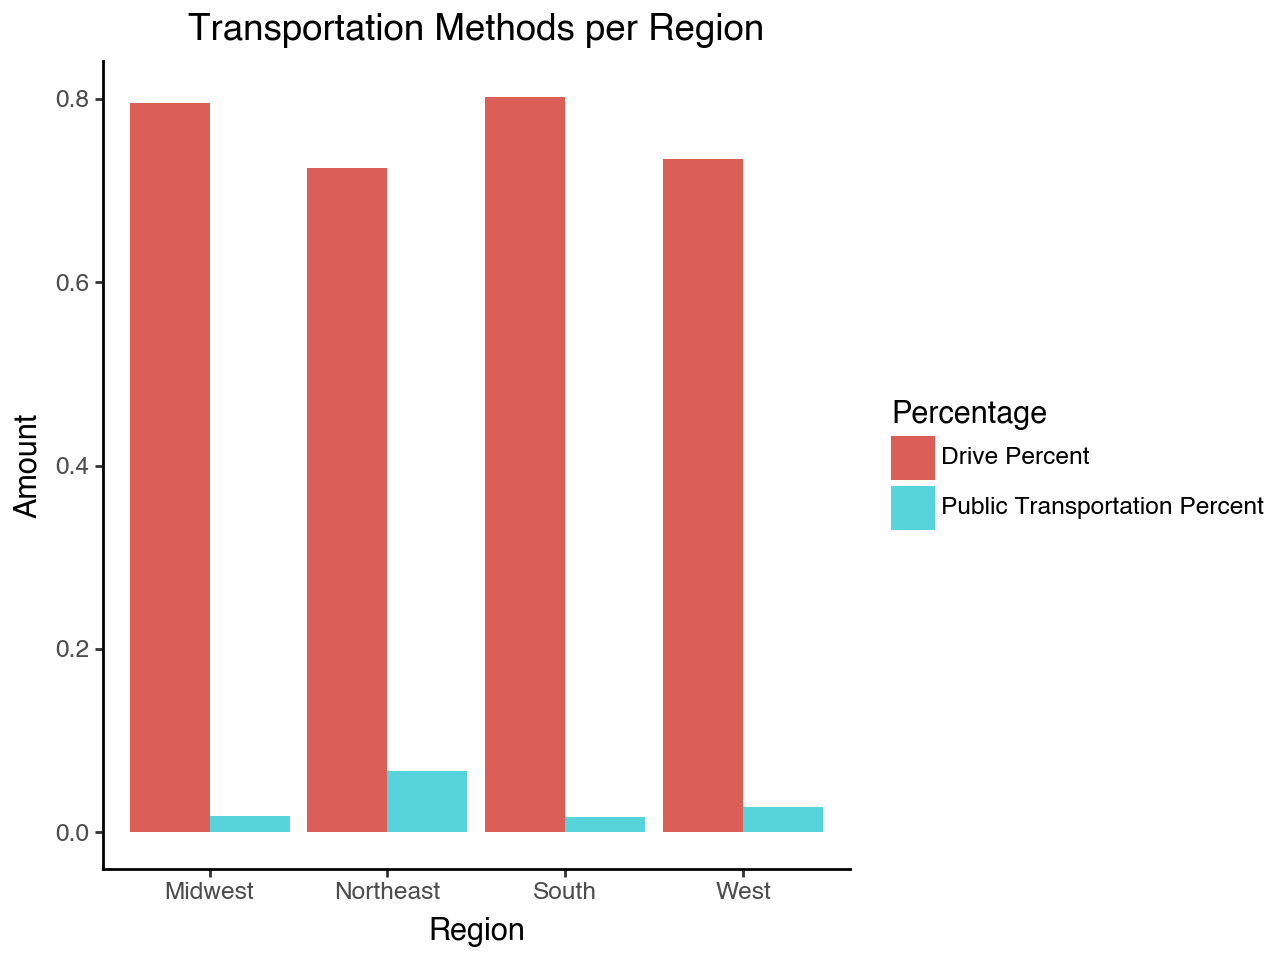

In [146]:
myData_mean_melted = pd.melt(myData_mean, id_vars=['Region'], value_vars=['Public Transportation Percent', 'Drive Percent'],
                             var_name='Percentage', value_name='Mode')

# Create the plot with side-by-side bars for Revenue and Expenditure
plot_Revenue_Expenditure = (ggplot(myData_mean_melted, aes(x='Region', y='Mode', fill='Percentage')) +
                           geom_bar(stat='identity', position='dodge') +  # Position bars side by side
                           labs(title='Transportation Methods per Region',
                                x='Region',
                                y='Amount') +
                           theme_classic())

# Show the plot
plot_Revenue_Expenditure.show()

In [ ]:
grouped_data = myData.groupby(['Region', 'Year']).agg({
    'Co2 Emission': 'mean',
    'Expenditure': 'sum',
    'Population': 'sum',
    'Public Transportation Percent': 'mean'
}).reset_index()


grouped_data['emissions_pop'] = grouped_data['Co2 Emission']/grouped_data['Population']
grouped_data.head()

In [16]:
from plotnine import ggplot, aes, geom_line, geom_point, labs, geom_smooth

In [ ]:
(ggplot(grouped_data, aes(x = "Year", y = 'emissions_pop', color = 'Region')) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  labs(
    title = "CO2 Emissions Over Time by Region",
    x = "Year",
    y = "CO2 Emissions",
    color = "Region"
  ))

In [ ]:
(
    ggplot(grouped_data, aes(x='Public Transportation Percent', y='Expenditure', color='Region')) +
    geom_point(size=4, alpha=0.8) +  # Larger points for better visibility
    labs(
        title="Expenditure vs. Public Transportation Percentage by Region",
        x="Mean Public Transportation Percentage",
        y="Total Expenditure",
        color="Region"
    )
)

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Create the binary target variable: 'High CO2' (1) if CO2 > threshold, else 'Low CO2' (0)
threshold = grouped_data['Co2 Emission'].median()  # Using median as a threshold example
grouped_data['CO2_Class'] = (grouped_data['Co2 Emission'] > threshold).astype(int)

# Define predictors and target
X = grouped_data[['Public Transportation Percent', 'Expenditure', 'Region', 'Population', 'Year', 'emissions_pop']]
y = grouped_data['CO2_Class']

# Preprocessing: Standardize numerical features and one-hot encode categorical features
numerical_features = ['Public Transportation Percent', 'Expenditure', 'Population', 'Year', 'emissions_pop' ]
categorical_features = ['Region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)
# Create a pipeline for logistic regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
evaluation_results = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Confusion Matrix': conf_matrix
}

# Display the results
#import ace_tools as tools; tools.display_dataframe_to_user(name="Logistic Regression Results", dataframe=pd.DataFrame([evaluation_results]))
print("Logistic Regression Results:")
display(pd.DataFrame([evaluation_results]))

# Print the feature importance from logistic regression coefficients
logistic_model = pipeline.named_steps['classifier']
feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].get_feature_names_out())
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logistic_model.coef_[0]
})
#tools.display_dataframe_to_user(name="Feature Importance", dataframe=feature_importance)
# Display the Feature Importance DataFrame using pandas' display function
print("\nFeature Importance:")
display(feature_importance)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define predictors and target
X = grouped_data[['Public Transportation Percent', 'Expenditure', 'Region', 'Population', 'Year', 'emissions_pop']]
y = grouped_data['Co2 Emission']

# Preprocessing: Standardize numerical features and one-hot encode categorical features
numerical_features = ['Public Transportation Percent', 'Expenditure', 'Population', 'Year', 'emissions_pop' ]
categorical_features = ['Region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Create a pipeline for linear regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Collect evaluation results
evaluation_results = {
    'Mean Squared Error': mse,
    'R-Squared': r2
}

# Extract feature importance (coefficients)
linear_model = pipeline.named_steps['regressor']
feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].get_feature_names_out())
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': linear_model.coef_
})

# Display results to the user
print("Linear Regression Results:")
display(pd.DataFrame([evaluation_results]))
print("\nFeature Coefficients:")
display(coefficients)

In [38]:
def tune_model(model_type, pipeline, X, y, param_grid):
    """
    Tunes a regularized regression model using GridSearchCV.

    Parameters:
    model_type (str): Type of regularized regression ('lasso', 'ridge', or 'elasticnet').
    pipeline (Pipeline): Scikit-learn pipeline with preprocessing.
    X (DataFrame): Predictor variables.
    y (Series): Target variable.
    param_grid (dict): Parameter grid for hyperparameter tuning.
    cv (int): Number of cross-validation folds.

    Returns:
    GridSearchCV: Fitted GridSearchCV object with the best parameters.
    """
    # Select the model based on the input parameter
    if model_type == 'lasso':
        model = Lasso()
    elif model_type == 'ridge':
        model = Ridge()
    elif model_type == 'elasticnet':
        model = ElasticNet()
    else:
        raise ValueError("Invalid model_type. Choose from 'lasso', 'ridge', or 'elasticnet'.")

    # Update the pipeline with the selected model
    pipeline.steps[-1] = ('regressor', model)

    # Set up GridSearchCV with the pipeline and the parameter grid
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    
    # Fit the grid search
    grid_search.fit(X, y)
    
    # Display best parameters and corresponding MSE
    print(f"Best parameters for {grid_search.best_params_}")
    
    return grid_search


In [104]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Define predictors and target
X = myData[['Public Transportation Percent', 'expenditure_pop', 'Region', "Drive Percent", "revenue_pop"]]
y = myData['Co2 Emission']

# Preprocessing: Standardize numerical features and one-hot encode categorical features
numerical_features = ['Public Transportation Percent', 'expenditure_pop', "Drive Percent", "revenue_pop" ]
categorical_features = ['Region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Create a pipeline for linear regression
pipeline_en = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for Ridge regression
en_param_grid = {
    #'preprocessor__poly_PT__degree': np.arange(1, 9),
    'regressor__alpha': [0.01, 0.1, 1],
    'regressor__l1_ratio': [0.5, 0.65, 0.9, 1.0]
}

# Tune the Ridge model
tuned_en = tune_model('elasticnet', pipeline_en, X_train, y_train, en_param_grid)
best_en = tuned_en.best_estimator_

# Train the linear regression model
tuned_en.fit(X_train, y_train)

# Predictions
y_pred = tuned_en.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Collect evaluation results
evaluation_results = {
    'RootMean Squared Error': mse,
    'R-Squared': r2
}


# Extract feature importance (coefficients)
model = tuned_en.best_estimator_['regressor']
feature_names = tuned_en.best_estimator_['preprocessor'].transformers_[0][2] + \
               list(tuned_en.best_estimator_['preprocessor'].transformers_[1][1].get_feature_names_out())
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_
})

# Display results to the user
print("Linear Regression Results:")
display(pd.DataFrame([evaluation_results]))
print("\nFeature Coefficients:")
display(coefficients)

Best parameters for {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.65}
Linear Regression Results:


,RootMean Squared Error,R-Squared
0,32.051031,0.132432



Feature Coefficients:


,Feature,Coefficient
0,Public Transportation Percent,11.209511
1,expenditure_pop,-2.082625
2,Drive Percent,-2.757005
3,revenue_pop,-1.563963
4,Region_Northeast,-13.371688
5,Region_South,15.894427
6,Region_West,-0.000000


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define predictors and target
X = grouped_data[['Public Transportation Percent', 'Expenditure', 'Region', 'Population', 'Year', 'emissions_pop']]
y = grouped_data['Co2 Emission']

# Preprocessing: Standardize numerical features and one-hot encode categorical features
numerical_features = ['Public Transportation Percent', 'Expenditure', 'Population', 'Year', 'emissions_pop']
categorical_features = ['Region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Create a pipeline for decision tree regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the decision tree model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Collect evaluation results
evaluation_results = {
    'Mean Squared Error': mse,
    'R-Squared': r2
}

# Extract feature importance (using feature_importances_ instead of coef_)
tree_model = pipeline.named_steps['regressor']  # Renamed to tree_model for clarity
feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].get_feature_names_out())
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Importance': tree_model.feature_importances_  # Changed to feature_importances_
})

# Display the evaluation results
print("Decision Tree Regression Results:")
display(pd.DataFrame([evaluation_results]))
print("\nFeature Coefficients:")
display(coefficients)

In [132]:
import pandas as pd

avg_PTP = myData["Public Transportation Percent"].mean()
avg_DP = myData["Drive Percent"].mean()
avg_rev =  myData["revenue_pop"].mean()
standard_region = "West"
min_expenditure = myData['Expenditure'].min()
max_expenditure = myData['Expenditure'].max()


sim_data = {"Public Transportation Percent": [avg_PTP]*100,
            "expenditure_pop": np.linspace(min_expenditure, max_expenditure, 100),
            "Drive Percent": [avg_DP]*100,
            "revenue_pop":[avg_rev]*100,
            "Region":[standard_region]*100,}

df = pd.DataFrame(sim_data)
X_pred = df[['Public Transportation Percent', 'expenditure_pop', 'Region', "Drive Percent", "revenue_pop"]]


df['Predicted_CO2'] = tuned_en.predict(X_pred) + 5.186237e+08

df

,Public Transportation Percent,expenditure_pop,Drive Percent,revenue_pop,Region,Predicted_CO2
0,0.028852,7.652477e+06,0.768624,12.140942,West,5.136963e+08
1,0.028852,1.571091e+07,0.768624,12.140942,West,5.085074e+08
2,0.028852,2.376934e+07,0.768624,12.140942,West,5.033186e+08
3,0.028852,3.182777e+07,0.768624,12.140942,West,4.981297e+08
4,0.028852,3.988621e+07,0.768624,12.140942,West,4.929409e+08
...,...,...,...,...,...,...
95,0.028852,7.732035e+08,0.768624,12.140942,West,2.075544e+07
96,0.028852,7.812620e+08,0.768624,12.140942,West,1.556659e+07
97,0.028852,7.893204e+08,0.768624,12.140942,West,1.037774e+07
98,0.028852,7.973788e+08,0.768624,12.140942,West,5.188887e+06


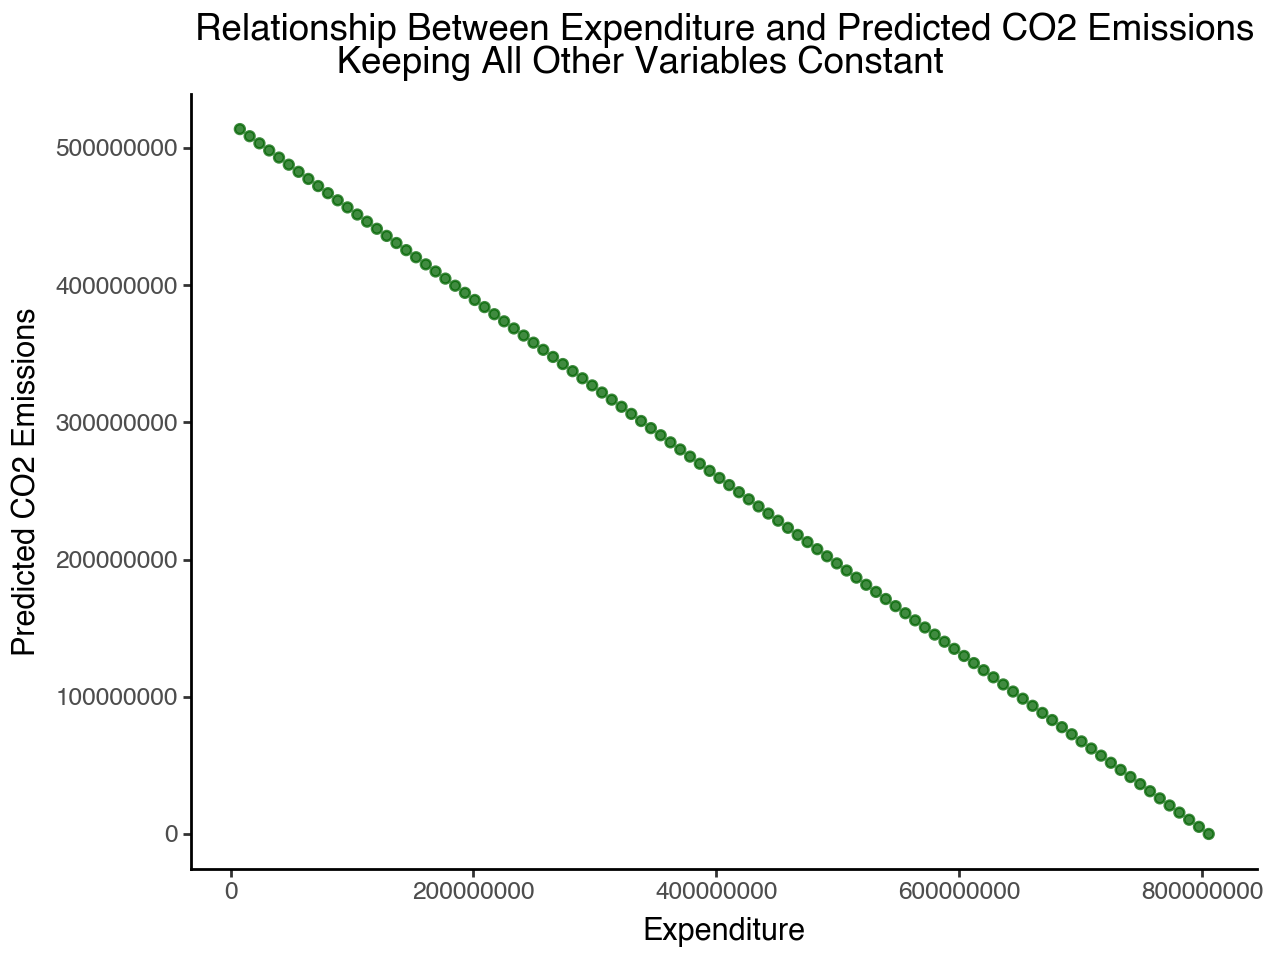

In [144]:
from plotnine import theme_minimal

plot_expenditure = (
    ggplot(df, aes(x='expenditure_pop', y='Predicted_CO2'))
    + geom_point(alpha= .75, color= 'darkgreen')
    + labs(title='Relationship Between Expenditure and Predicted CO2 Emissions\n              Keeping All Other Variables Constant',
           x='Expenditure',
           y='Predicted CO2 Emissions')
    + theme_classic()
)

plot_expenditure.show()